<a href="https://colab.research.google.com/github/miloszpiechota/AI-Systems/blob/main/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('data.csv')
df.head()
df.drop('Tm',axis=1,inplace=True)
X=df.iloc[:,0:27]
y = df.iloc[:,27]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=21)
scaleStandard = StandardScaler()
X_train = scaleStandard.fit_transform(X_train)
X_test = scaleStandard.transform(X_test)
df.columns

X_train=pd.DataFrame(X_train,columns=['A','B','C'])

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca1=PCA()
X_pca1 = pca1.fit_transform(X_train)
pca1.explained_variance_ratio_
plt.plot(pca1.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

pca2=PCA(0.95)
X_pca2 = pca2.fit_transform(X_train)
X_pca2.shape
pca2.explained_variance_ratio_

pca2c = PCA(n_components=2)
X_pca2c = pca2c.fit_transform(X_train)

colormap=plt.cm.get_cmap('coolwarm')
plt.figure()
scatter = plt.scatter(X_pca2c[:,0],X_pca2c[:,1],c=y_train,cmap=colormap)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter)
plt.show()

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from scipy import stats
import os

# Define file paths
feature_names_file = 'sample_data/features.txt'
activity_labels_file = 'sample_data/activity_labels.txt'
train_data_file = 'sample_data/train/X_train.txt'
train_labels_file = 'sample_data/train/y_train.txt'
train_subjects_file = 'sample_data/train/subject_train.txt'
test_data_file = 'sample_data/test/X_test.txt'
test_labels_file = 'sample_data/test/y_test.txt'
test_subjects_file = 'sample_data/test/subject_test.txt'

# Load feature names
feature_names = pd.read_csv(feature_names_file, delim_whitespace=True, header=None, usecols=[1])
feature_names = feature_names[1].tolist()

# Load activity labels
activity_labels = pd.read_csv(activity_labels_file, delim_whitespace=True, header=None, index_col=0)
activity_labels_dict = activity_labels[1].to_dict()

# Load training data
X_train = pd.read_csv(train_data_file, delim_whitespace=True, header=None)
y_train = pd.read_csv(train_labels_file, delim_whitespace=True, header=None)
subject_train = pd.read_csv(train_subjects_file, delim_whitespace=True, header=None)

# Load test data
X_test = pd.read_csv(test_data_file, delim_whitespace=True, header=None)
y_test = pd.read_csv(test_labels_file, delim_whitespace=True, header=None)
subject_test = pd.read_csv(test_subjects_file, delim_whitespace=True, header=None)

# Combine training and test data
X = pd.concat([X_train, X_test], ignore_index=True)
y = pd.concat([y_train, y_test], ignore_index=True)
subjects = pd.concat([subject_train, subject_test], ignore_index=True)

# Assign column names
X.columns = feature_names
y.columns = ['Activity']
subjects.columns = ['Subject']

# Map activity labels
y['Activity'] = y['Activity'].map(activity_labels_dict)

# Combine all data into a single DataFrame
data = pd.concat([subjects, y, X], axis=1)

# Handle missing values (if any)
data.dropna(inplace=True)

# Remove outliers using Z-score
z_scores = np.abs(stats.zscore(data.iloc[:, 2:]))
data = data[(z_scores < 3).all(axis=1)]

# Remove low-variance features
selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(data.iloc[:, 2:])
selected_features = data.iloc[:, 2:].columns[selector.get_support(indices=True)]
data_reduced = pd.DataFrame(X_reduced, columns=selected_features)
data = pd.concat([data.iloc[:, :2].reset_index(drop=True), data_reduced], axis=1)

# Remove highly correlated features
corr_matrix = data.iloc[:, 2:].corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
data.drop(columns=to_drop, inplace=True)

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(data.iloc[:, 2:])
data_scaled = pd.DataFrame(features_scaled, columns=data.columns[2:])
data_scaled = pd.concat([data.iloc[:, :2].reset_index(drop=True), data_scaled], axis=1)

# Save the cleaned and standardized data
data_scaled.to_csv('cleaned_data.csv', index=False)

# Apply PCA to retain 95% of variance
pca = PCA(n_components=0.95, random_state=42)
principal_components = pca.fit_transform(data_scaled.iloc[:, 2:])
pca_columns = [f'PC{i+1}' for i in range(principal_components.shape[1])]
pca_data = pd.DataFrame(principal_components, columns=pca_columns)
pca_data = pd.concat([data_scaled.iloc[:, :2].reset_index(drop=True), pca_data], axis=1)

# Save the PCA-transformed data
pca_data.to_csv('pca_data.csv', index=False)

print("Data preprocessing complete. 'cleaned_data.csv' and 'pca_data.csv' have been saved.")


<ipython-input-2-d5c80cd8a798>:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  feature_names = pd.read_csv(feature_names_file, delim_whitespace=True, header=None, usecols=[1])
<ipython-input-2-d5c80cd8a798>:25: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  activity_labels = pd.read_csv(activity_labels_file, delim_whitespace=True, header=None, index_col=0)
<ipython-input-2-d5c80cd8a798>:29: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(train_data_file, delim_whitespace=True, header=None)
<ipython-input-2-d5c80cd8a798>:30: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_train = p

Data preprocessing complete. 'cleaned_data.csv' and 'pca_data.csv' have been saved.


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load datasets
full_data = pd.read_csv('cleaned_data.csv')
pca_data = pd.read_csv('pca_data.csv')

# Encode activity labels
label_encoder = LabelEncoder()
full_data['Activity'] = label_encoder.fit_transform(full_data['Activity'])
pca_data['Activity'] = label_encoder.transform(pca_data['Activity'])

# Separate features and labels
X_full = full_data.drop(['Subject', 'Activity'], axis=1)
y_full = full_data['Activity']
X_pca = pca_data.drop(['Subject', 'Activity'], axis=1)
y_pca = pca_data['Activity']

# Split into training and testing sets
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42, stratify=y_full)
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, y_pca, test_size=0.2, random_state=42, stratify=y_pca)

# Standardize features
scaler_full = StandardScaler()
X_full_train_scaled = scaler_full.fit_transform(X_full_train)
X_full_test_scaled = scaler_full.transform(X_full_test)

scaler_pca = StandardScaler()
X_pca_train_scaled = scaler_pca.fit_transform(X_pca_train)
X_pca_test_scaled = scaler_pca.transform(X_pca_test)

# Initialize results dictionary
results = {}

# 1. Logistic Regression
lr_full = LogisticRegression(max_iter=1000)
lr_full.fit(X_full_train_scaled, y_full_train)
lr_full_acc = accuracy_score(y_full_test, lr_full.predict(X_full_test_scaled))
results['Logistic Regression'] = {'Full': lr_full_acc}

lr_pca = LogisticRegression(max_iter=1000)
lr_pca.fit(X_pca_train_scaled, y_pca_train)
lr_pca_acc = accuracy_score(y_pca_test, lr_pca.predict(X_pca_test_scaled))
results['Logistic Regression']['PCA'] = lr_pca_acc

# 2. Random Forest
rf_full = RandomForestClassifier(n_estimators=100, random_state=42)
rf_full.fit(X_full_train_scaled, y_full_train)
rf_full_acc = accuracy_score(y_full_test, rf_full.predict(X_full_test_scaled))
results['Random Forest'] = {'Full': rf_full_acc}

rf_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pca.fit(X_pca_train_scaled, y_pca_train)
rf_pca_acc = accuracy_score(y_pca_test, rf_pca.predict(X_pca_test_scaled))
results['Random Forest']['PCA'] = rf_pca_acc

# 3. Support Vector Machine
svm_full = SVC()
svm_full.fit(X_full_train_scaled, y_full_train)
svm_full_acc = accuracy_score(y_full_test, svm_full.predict(X_full_test_scaled))
results['Support Vector Machine'] = {'Full': svm_full_acc}

svm_pca = SVC()
svm_pca.fit(X_pca_train_scaled, y_pca_train)
svm_pca_acc = accuracy_score(y_pca_test, svm_pca.predict(X_pca_test_scaled))
results['Support Vector Machine']['PCA'] = svm_pca_acc

# Prepare labels for neural networks
num_classes = len(np.unique(y_full))
y_full_train_cat = to_categorical(y_full_train, num_classes)
y_full_test_cat = to_categorical(y_full_test, num_classes)
y_pca_train_cat = to_categorical(y_pca_train, num_classes)
y_pca_test_cat = to_categorical(y_pca_test, num_classes)

# 4. Shallow Neural Network
def create_shallow_nn(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Full features
shallow_nn_full = create_shallow_nn(X_full_train_scaled.shape[1], num_classes)
shallow_nn_full.fit(X_full_train_scaled, y_full_train_cat, epochs=20, batch_size=32, verbose=0)
shallow_nn_full_acc = shallow_nn_full.evaluate(X_full_test_scaled, y_full_test_cat, verbose=0)[1]
results['Shallow Neural Network'] = {'Full': shallow_nn_full_acc}



# 5. Deep Neural Network
def create_deep_nn(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Full features
deep_nn_full = create_deep_nn(X_full_train_scaled.shape[1], num_classes)
deep_nn_full.fit(X_full_train_scaled, y_full_train_cat, epochs=20, batch_size=32, verbose=0)
deep_nn_full_acc = deep_nn_full.evaluate(X_full_test_scaled, y_full_test_cat, verbose=0)[1]
results['Deep Neural Network'] = {'Full': deep_nn_full_acc}

# PCA features
deep_nn_pca = create_deep_nn(X_pca_train_scaled.shape[1], num_classes)
deep_nn_pca.fit(X_pca_train_scaled, y_pca_train_cat, epochs=20, batch_size=32, verbose=0)
deep_nn_pca_acc = deep_nn_pca.evaluate(X_pca_test_scaled, y_pca_test_cat, verbose=0)[1]
results['Deep Neural Network']['PCA'] = deep_nn_pca_acc

# Display the results
print("Model Evaluation Results:")
print("{:<25} {:<20} {:<20}".format("Model", "Full Features Accuracy", "PCA Features Accuracy"))
for model_name, accuracies in results.items():
    full_acc = f"{accuracies['Full']*100:.2f}%" if 'Full' in accuracies else "N/A"
    pca_acc = f"{accuracies['PCA']*100:.2f}%" if 'PCA' in accuracies else "N/A"
    print(f"{model_name:<25} {full_acc:<20} {pca_acc:<20}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Evaluation Results:
Model                     Full Features Accuracy PCA Features Accuracy
Logistic Regression       82.89%               77.63%              
Random Forest             85.53%               72.37%              
Support Vector Machine    84.21%               76.32%              
Shallow Neural Network    76.32%               N/A                 
Deep Neural Network       81.58%               65.79%              


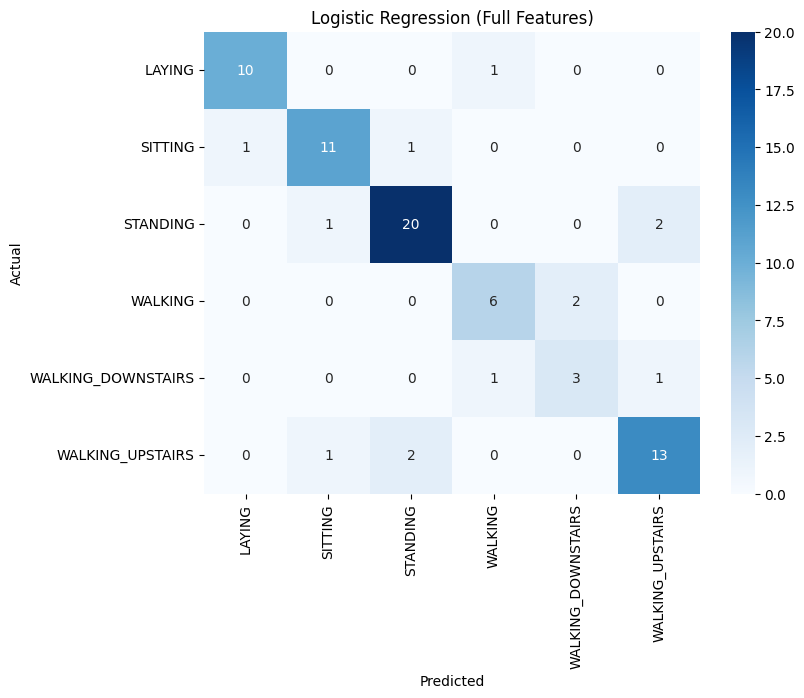

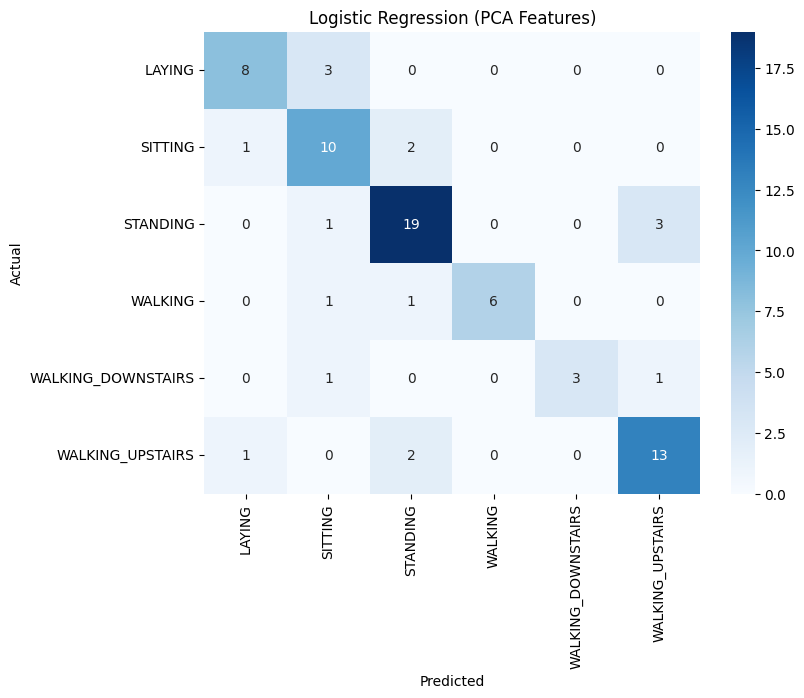

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


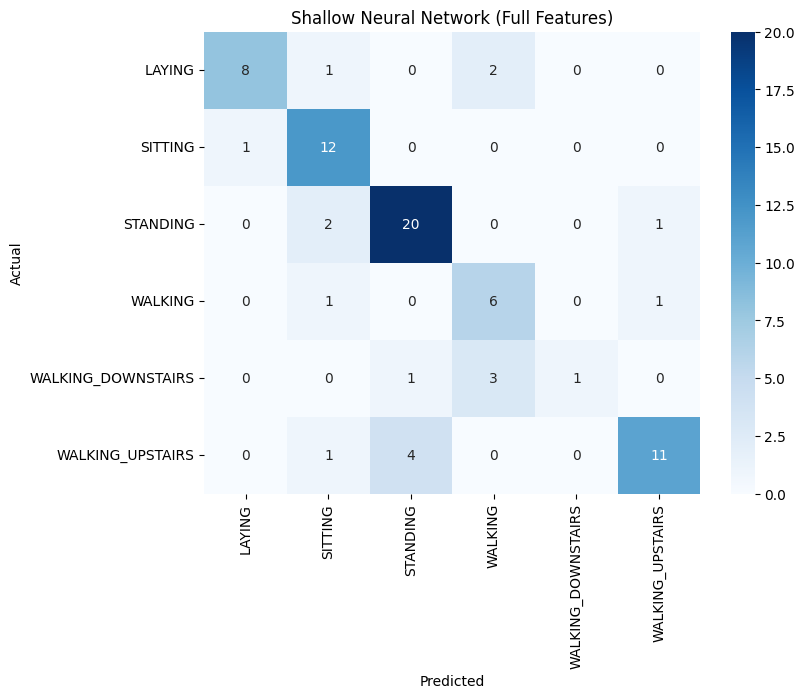

NameError: name 'shallow_nn_pca' is not defined

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
# Example for Logistic Regression with full features
plot_confusion_matrix(y_full_test, lr_full.predict(X_full_test_scaled),
                      label_encoder.classes_, 'Logistic Regression (Full Features)')

# Example for Logistic Regression with PCA features
plot_confusion_matrix(y_pca_test, lr_pca.predict(X_pca_test_scaled),
                      label_encoder.classes_, 'Logistic Regression (PCA Features)')

# Repeat similarly for other models:
# Random Forest, SVM, Shallow Neural Network, Deep Neural Network
# For Shallow Neural Network with full features
shallow_nn_full_preds = shallow_nn_full.predict(X_full_test_scaled)
shallow_nn_full_preds_labels = shallow_nn_full_preds.argmax(axis=1)
plot_confusion_matrix(y_full_test, shallow_nn_full_preds_labels,
                      label_encoder.classes_, 'Shallow Neural Network (Full Features)')

# For Shallow Neural Network with PCA features
shallow_nn_pca_preds = shallow_nn_pca.predict(X_pca_test_scaled)
shallow_nn_pca_preds_labels = shallow_nn_pca_preds.argmax(axis=1)
plot_confusion_matrix(y_pca_test, shallow_nn_pca_preds_labels,
                      label_encoder.classes_, 'Shallow Neural Network (PCA Features)')

# Similarly for Deep Neural Network
